Authors: Grant M. Chou, Chris J. Dallmann \
Affiliation: University of Washington, Seattle \
Last revision: 31-July-2025

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
df_9A_silencing = pd.read_parquet('../data/9A_silencing.pq')
df_control_silencing = pd.read_parquet('../data/control_silencing.pq')
df_9A_activation = pd.read_parquet('../data/9A_activation.pq')
df_control_activation = pd.read_parquet('../data/control_activation.pq')

In [3]:
# Settings
legs = ['L1','R1','L2','R2','L3','R3']
label_dict = {'A_flex':'Coxa flexion (°)', 'A_rot':'Coxa rotation (°)', 'A_abduct':'Coxa abduction (°)',
              'B_rot':'Femur rotation (°)', 'B_flex':'Femur flexion (°)', 
              'C_rot':'Tibia rotation (°)', 'C_flex':'Tibia flexion (°)', 'D_flex':'Tarsus flexion (°)',
              'E_y': 'Tarsus anterior-posterior',
              'forward_velocity': 'Forward velocity (mm/s)', 
              'angular_velocity': 'Angular velocity (°/s)'
             }

In [4]:
# Plot example trace
def plot_example_trace(df, vid, y1='L1C_flex', y2='forward_velocity'):

    # Initialize figure
    fig,ax = plt.subplots(2,1, figsize=(6,4), sharex=True)
    trial = df['fullfile'] == vid
    
    if 'C_flex' in y1:
        df.loc[trial,y1] = df.loc[trial,y1].abs()
    if 'C_flex' in y2:
        df.loc[trial,y2] = df.loc[trial,y2].abs()
    
    ax[0].plot(df.loc[trial,'fnum']/300, df.loc[trial,y1], c='tab:blue')
    ax[1].plot(df.loc[trial,'fnum']/300, df.loc[trial,y2], c='tab:gray')
    ax[0].axvspan(0.5,1.5, color='tab:gray', alpha=0.2)
    ax[1].axvspan(0.5,1.5, color='tab:gray', alpha=0.2)
    
    fig.suptitle(vid)
    
    ax[0].set_xlim(0,2)
    ax[0].set_ylim(20,150)
    ax[0].set_yticks([30,90,150])
    
    ax[1].set_xlim(0,2)
    ax[1].set_ylim(-2,22)
    ax[1].set_yticks([0,10,20])
    
    ax[1].set_xlabel('Time (s)')
    
    if any(leg in y1 for leg in legs):
        ax[0].set_ylabel(label_dict[y1[2:]]) # Assuming that y1 is a joint angle
    else:
        ax[0].set_ylabel(label_dict[y1])
    
    if any(leg in y2 for leg in legs):
        ax[1].set_ylabel(label_dict[y2[2:]]) # Assuming that y1 is a joint angle
    else:
        ax[1].set_ylabel(label_dict[y2])
    
    sns.despine()

In [5]:
# Filter for forward walking
def get_forward_walking(df):
    df = df.reset_index(drop=True)
    
    trials = df.groupby(['fullfile', 'trial_phase'])[['forward_velocity', 'angular_velocity']]
    trial_stats = trials.agg(['mean', 'min', 'max', 'count']).reset_index()

    avg_speed = trial_stats[('forward_velocity','mean')] >= 5
    avg_rot = trial_stats[('angular_velocity','mean')].abs() <= 400

    qualified_trials = trial_stats.loc[avg_speed]['fullfile'].unique()
    df = df.loc[df['fullfile'].isin(qualified_trials)]
    
    return df

In [6]:
# Plot average trace
def plot_average_trace(ctrl_df, exp_df, to_plot, colors=['k','teal']):

    # Initialize figure
    fig = plt.figure(figsize=(6,5))
    ax = plt.axes()
    labels = ['Control', 'Experimental']

    # Loop over datasets
    for c, df in enumerate([ctrl_df, exp_df]):
        
        df = df.reset_index(drop=True)

        # Filter for forward walking
        df = get_forward_walking(df)
        
        # Set time intervals
        time_bins = np.arange(0,601,20)
        df['interval'] = df['fnum']
        step_time_bins = pd.cut(df[f'interval'].sort_values(), time_bins)
        intervals = step_time_bins.dropna().unique()

        # Initialize variables
        mean = np.array([])
        sem = np.array([])
        time = np.array([])
        n_flies = df['flyid'].unique().size

        # Display number of animals
        print(f'{labels[c]}: N = {n_flies} flies')

        # Compute means per time interval
        df_all_intervals = df.groupby(['flyid',step_time_bins], observed=False)[[to_plot, 'fnum']].agg(['mean','count']).reset_index()
        
        # Loop over time intervals
        for i in range(len(intervals)):

            # Get data for current interval
            df_interval = df_all_intervals.loc[df_all_intervals['interval'] == intervals[i]]

            # Compute mean of animal animals
            bin_mean = df_interval[(to_plot,'mean')].mean()
            mean = np.append(mean, bin_mean)

            # Compute sem of animal means
            bin_std = df_interval[(to_plot,'mean')].std()
            bin_sem = bin_std / np.sqrt(n_flies)
            sem = np.append(sem, bin_sem)

            bin_time = df_interval[('fnum','mean')].mean()
            time = np.append(time, intervals[i].left)

        # Plot
        time = (time+intervals[0].mid)/300
        ax.plot(time, mean, color=colors[c], label=labels[c]) 
        ax.fill_between(time, mean-sem, mean+sem, color=colors[c], alpha=0.15) 
        ax.axvspan(0.5, 0.5+1, color='tab:gray', alpha=0.1)

    ax.set_xlim(0,2)
    ax.set_ylim(0,15)
    ax.set_xticks(np.arange(0,2.1,0.5))
    ax.set_yticks(np.arange(0,16,5))
    ax.set_xlabel('Time (s)', fontsize=12)
    
    if any(leg in to_plot for leg in legs):
        ax.set_ylabel(label_dict[to_plot[2:]]) # Assuming that y1 is a joint angle
    else:
        ax.set_ylabel(label_dict[to_plot])
        
    fig.legend()
    sns.despine()

In [7]:
def plot_phase_angle(df, leg='L1', joint='C_flex', colors = ['k','teal']): 

    # Initialize figure
    fig = plt.figure()
    ax = plt.axes()
    labels = ['Before', 'During']

    # Filter for forward walking
    df = get_forward_walking(df)
  
    ctrl_index = (df['trial_phase'] == 'Pre-stim')
    stim_index = (df['trial_phase'] == 'Stim on')

    ctrl_group = df.loc[ctrl_index].groupby(['flyid','fullfile',f'{leg}_bout_step_num'])[[f'{leg}{joint}']].agg("mean").reset_index()
    stim_group = df.loc[stim_index].groupby(['flyid','fullfile',f'{leg}_bout_step_num'])[[f'{leg}{joint}']].agg("mean").reset_index()

    # Set bins
    phase_bins = np.linspace(-np.pi,np.pi,25)
        
    # Loop over datasets
    for c, group in enumerate([ctrl_group, stim_group]):    
        all_vid_means = []
       
        # Loop over files
        for vid in group['fullfile'].unique():
            is_vid = group['fullfile'] == vid
            vid_group = group.loc[is_vid]

            steps = vid_group[leg+'_bout_step_num'].unique()
            steps_index = (df['fullfile'] == vid) & (df[leg+'_bout_step_num'].isin(steps))

            df_vid = df.loc[steps_index]

            # Loop over bins
            vid_mean_step = []
            for i in range(len(phase_bins)-1):
                
                # Get data for current bin
                bin_index = (df_vid[leg+'E_y_phase'] >= phase_bins[i]) & (df_vid[leg+'E_y_phase'] < phase_bins[i+1])
                
                # Compute mean
                mean = df_vid.loc[bin_index, leg+joint].mean()              
                vid_mean_step.append(mean)
            
            all_vid_means.append(vid_mean_step)

        all_vid_means = np.array(all_vid_means)       
        group_mean_step = np.nanmean(all_vid_means, axis=0)
        group_sd_step = np.nanstd(all_vid_means, axis=0)

        n_flies = group['flyid'].unique().size

        # Compute sem
        group_sem = group_sd_step / np.sqrt(n_flies)

        # Plot
        bin_width = phase_bins[1]-phase_bins[0]
        ax.plot(phase_bins[:-1]+bin_width/2, group_mean_step, c=colors[c], label=labels[c])
        ax.fill_between(phase_bins[:-1]+bin_width/2, group_mean_step-group_sem, group_mean_step+group_sem, color=colors[c], alpha=0.2)  

    # Display number of animals
    print(f'N = {n_flies} flies')
    
    ax.set_xlim(-np.pi,np.pi)
    ax.set_xticks([-np.pi,0,np.pi])
    ax.set_xticklabels(['$-\pi$','0','$\pi$'],fontsize=12)
    ax.set_xlabel('Step phase')
    
    ax.set_ylim(55,125)
    ax.set_yticks([60,90,120])
    ax.set_ylabel(label_dict[joint])
    
    fig.legend()
    sns.despine()

In [8]:
def compute_amplitude_differences(df):

    # Filter for forward walking
    df = get_forward_walking(df)
    
    ctrl_index = (df['trial_phase'] == 'Pre-stim')
    stim_index = (df['trial_phase'] == 'Stim on')

    legs = ['L1','R1','L2','R2','L3','R3']
    leg_vars = ['A_flex','A_rot','A_abduct','B_flex','B_rot','C_flex','C_rot','D_flex']

    joints = [angle for angle in leg_vars]
    amp_diff = pd.DataFrame(index=legs, columns=joints)

    # Loop over legs
    for leg in legs:

        # Loop over joints
        for joint in joints:
            # Calculate amplitude (difference between maximum value and minimum value)
            ctrl_group = df.loc[ctrl_index].groupby(['flyid','fullfile',f'{leg}_bout_step_num'])[[f'{leg}{joint}']].agg(np.ptp).reset_index()
            stim_group = df.loc[stim_index].groupby(['flyid','fullfile',f'{leg}_bout_step_num'])[[f'{leg}{joint}']].agg(np.ptp).reset_index()
            
            ctrl_amps = []
            stim_amps = []
    
            for fly in stim_group['flyid'].unique():
                stim_amps.append(stim_group.loc[stim_group['flyid'] == fly, f'{leg}{joint}'].mean())
    
            for fly in ctrl_group['flyid'].unique():
                ctrl_amps.append(ctrl_group.loc[ctrl_group['flyid'] == fly, f'{leg}{joint}'].mean())
    
            amp_diff.loc[leg, joint] = np.mean(np.array(stim_amps) - np.array(ctrl_amps))

    return amp_diff


def plot_heatmap(amp_diff, leg='L1'):
    
    fig = plt.figure(figsize=(11,1))
    ax = plt.axes()
    
    ylabels = ['Coxa \nflexion°', 'Coxa \nrotation°', 'Coxa \nabduction°', 'Femur \nflexion.°', 
               'Femur \nrotation°', 'Tibia \nflexion°', 'Tibia \nrotation°','Tarsus \nflexion°',]
    
    cmap = sns.diverging_palette(250, 320, as_cmap=True)
    sns.heatmap(amp_diff.T[[leg]].T.astype(np.float64), 
                ax=ax, 
                cmap=cmap, 
                cbar=True, 
                center=0, 
                annot=True, 
                fmt='.2f',vmin=-10,vmax=10, cbar_kws={"shrink": 2})
    ax.collections[0].colorbar.set_label(r'$°_{during} - °_{before}$', fontsize=10)
    ax.set_xticklabels(ylabels, rotation=0)
    ax.set_yticklabels([leg], rotation=0)

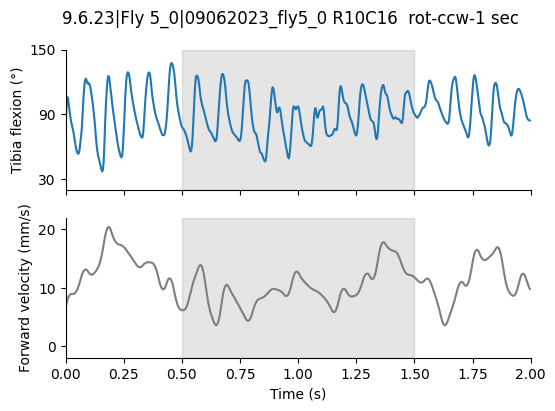

In [9]:
# Plot example of 9A silencing
vid = '9.6.23|Fly 5_0|09062023_fly5_0 R10C16  rot-ccw-1 sec'
plot_example_trace(df_9A_silencing, vid=vid, y1='L1C_flex', y2='forward_velocity')

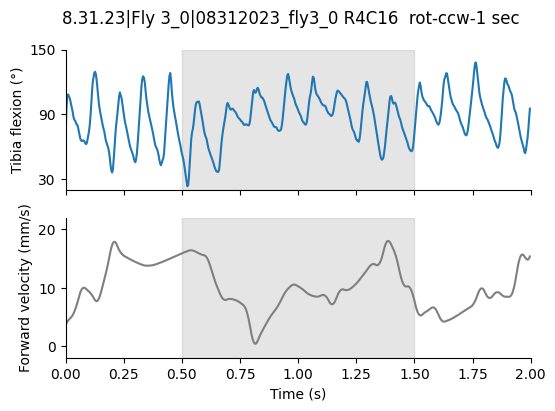

In [10]:
# Plot example of 9A activation
vid = '8.31.23|Fly 3_0|08312023_fly3_0 R4C16  rot-ccw-1 sec'
plot_example_trace(df_9A_activation, vid=vid, y1='L1C_flex', y2='forward_velocity')

Control: N = 10 flies
Experimental: N = 12 flies


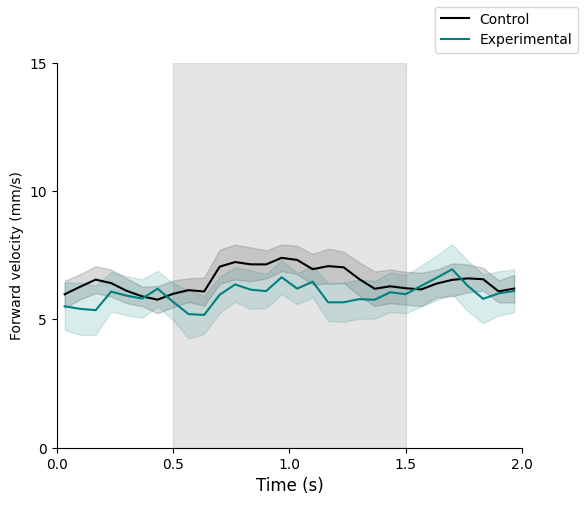

In [11]:
# Plot average forward velocity for silencing datasets
plot_average_trace(df_control_silencing, df_9A_silencing, 'forward_velocity')

Control: N = 8 flies
Experimental: N = 10 flies


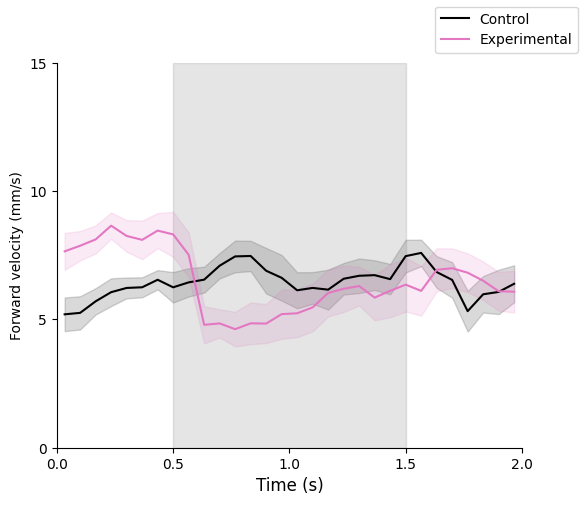

In [12]:
# Plot average forward velocity for activation datasets
plot_average_trace(df_control_activation, df_9A_activation, 'forward_velocity', colors=['k','tab:pink'])

N = 12 flies


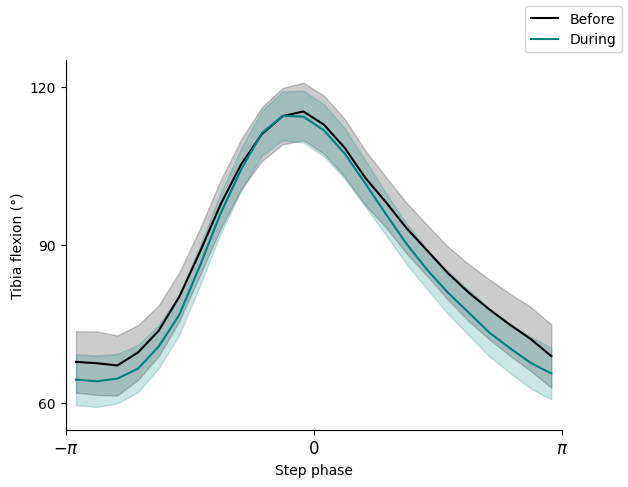

In [13]:
# Plot mean phase angle for 9A silencing
plot_phase_angle(df_9A_silencing, leg='L1', joint='C_flex', colors = ['k','teal'])

N = 10 flies


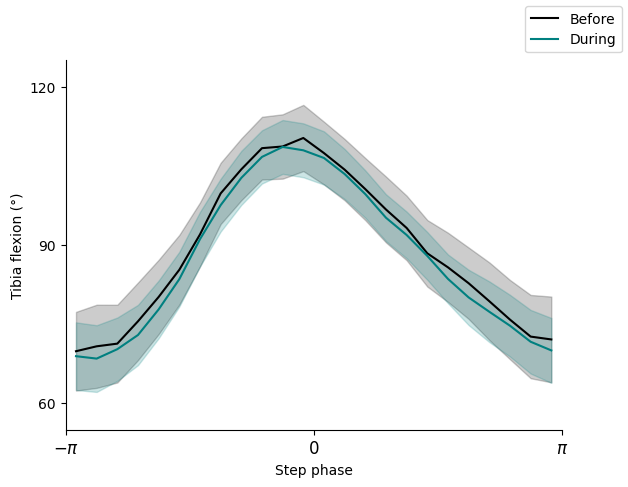

In [14]:
# Plot mean phase angle for control silencing 
plot_phase_angle(df_control_silencing, leg='L1', joint='C_flex', colors = ['k','teal'])

N = 10 flies


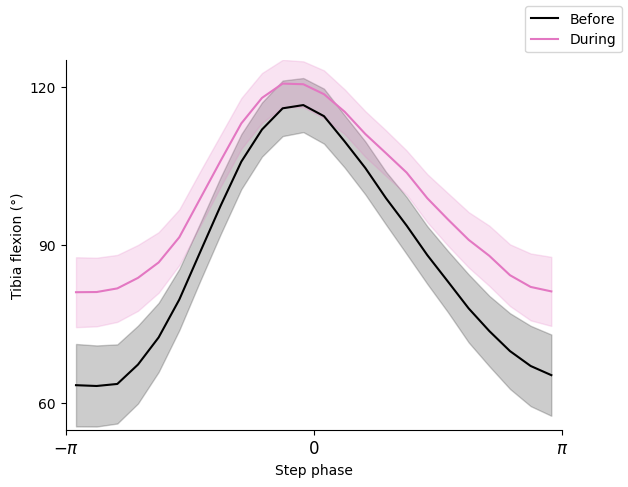

In [15]:
# Plot mean phase angle for 9A activation
plot_phase_angle(df_9A_activation, leg='L1', joint='C_flex', colors = ['k','tab:pink'])

N = 8 flies


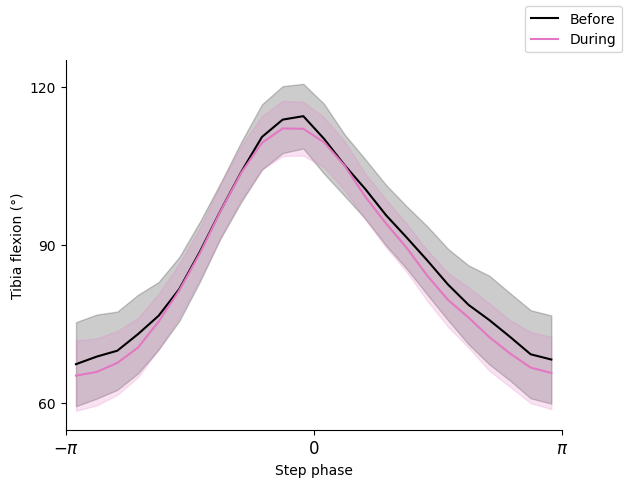

In [16]:
# Plot mean phase angle for control activation
plot_phase_angle(df_control_activation, leg='L1', joint='C_flex', colors = ['k','tab:pink'])

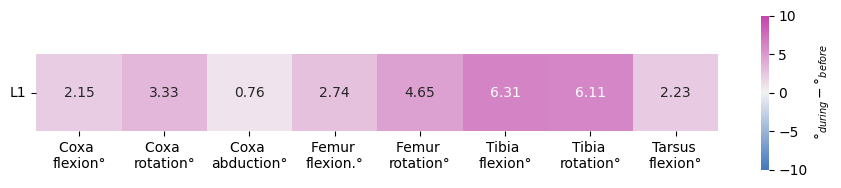

In [17]:
# Plot mean differences in joint angle amplitudes for 9A silencing
amplitude_differences = compute_amplitude_differences(df_9A_silencing)
plot_heatmap(amplitude_differences, leg='L1')

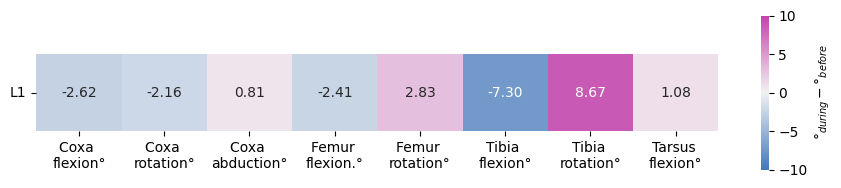

In [18]:
# Plot mean differences in joint angle amplitudes for 9A activation
amplitude_differences = compute_amplitude_differences(df_9A_activation)
plot_heatmap(amplitude_differences, leg='L1')